In [3]:
# run WinPython Command Prompt.exe
# pip install scikit-plot
# pip install xgboost
# pip install pydotplus

In [23]:
# edit your data file name here.
datafile = 'moon.xlsx'

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import Image
import scipy.stats as scs
import scikitplot as skplt  
import pydotplus
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import make_scorer

from sklearn.feature_selection import SelectKBest, chi2

from sklearn import tree

import warnings

warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
pd.options.display.max_columns = None # Show all columns
pd.options.display.max_rows = None # Show all columns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [25]:
import pandas as pd
data = pd.read_excel(datafile)
data.head()

,Possibility,Age,Menopause,Treatment,Diseases,MBNG,Stage,T,N,M,Infiltration,Her-2,Ki-67,Luminal,ER status,PR status
0,1,1,0,2,1,3,2,2,1,0,0,1,1,1,1,1
1,1,1,0,1,0,2,1,1,0,0,0,1,2,2,1,1
2,1,1,0,1,0,2,2,1,1,0,2,1,1,1,1,1
3,2,1,1,1,0,3,3,2,3,0,2,3,2,3,0,0
4,1,1,1,1,0,3,2,2,0,0,0,1,2,2,0,0


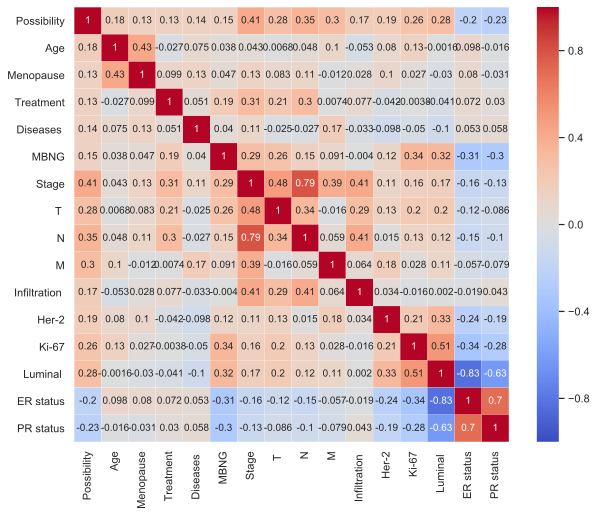

In [26]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), linewidths=0.1, square=True, cmap='coolwarm', linecolor='white', annot=True, vmax=1, vmin=-1);

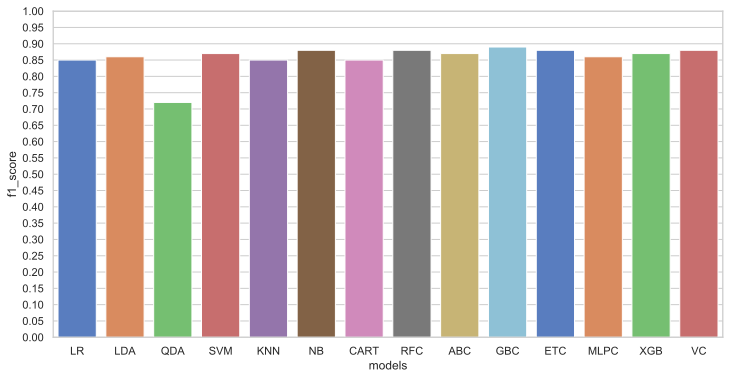

In [27]:
data = data.dropna()

X, y = data.values[:,1:], data.values[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

models = {
    'LR'  : LogisticRegression(),
    'LDA' : LinearDiscriminantAnalysis(),
    'QDA' : QuadraticDiscriminantAnalysis(),
    'SVM' : SVC(),
    'KNN' : KNeighborsClassifier(),
    'NB'  : GaussianNB(),
    'CART': DecisionTreeClassifier(),
    'RFC' : RandomForestClassifier(),
    'ABC' : AdaBoostClassifier(),
    'GBC' : GradientBoostingClassifier(),
    'ETC' : ExtraTreesClassifier(),
    'MLPC': MLPClassifier(),
    'XGB' : XGBClassifier()
}

models['VC'] = VotingClassifier(estimators=[
    ('lr', models['LR']), ('lda', models['LDA']), ('qda', models['QDA']),
    ('svm', models['SVM']),('knn', models['KNN']), ('nb', models['NB']), 
    ('cart', models['CART']), ('rfc', models['RFC']), ('abc', models['ABC']),
    ('gbc', models['GBC']), ('etc', models['ETC']), ('mlpc', models['MLPC']),
    ('xgb', models['XGB'])], voting='hard')

kfold = StratifiedKFold(n_splits=10, random_state=0)

cv_results = []

for key in models:
        cv_score = cross_val_score(models[key], X_train, y_train, scoring="f1", cv=kfold)
        cv_mean = round(cv_score.mean(), 2)
        cv_result = {'models': key, 'f1_score': cv_mean}
        cv_results.append(cv_result)

cv_results = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
cv_plot = sns.barplot(x='models', y='f1_score', data=cv_results, palette="muted");
cv_plot.set_yticks(np.arange(0, 1.05, 0.05));
# plt.savefig('modelselection.svg')

<Figure size 864x576 with 0 Axes>

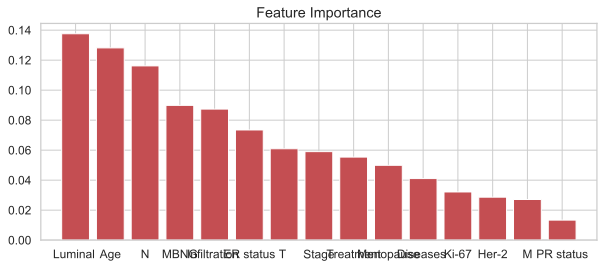

In [36]:
models['CART'].fit(X_train, y_train)
plt.figure(figsize=(12,8))
skplt.estimators.plot_feature_importances(models['CART'], feature_names=data.columns[1:], figsize=(10, 4))
# plt.savefig('feature.svg')

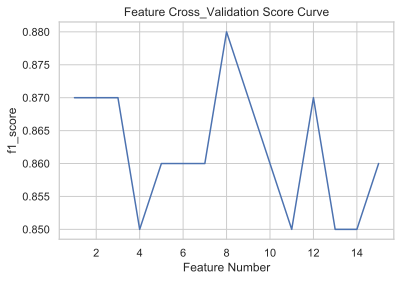

In [29]:
cv_means = []
cv_scores = []
X, y = data.values[:, 1:], data.values[:, 0]   
for i in range(1,data.shape[1]): 
    ch2=SelectKBest(chi2, k=i)
    fX = ch2.fit_transform(X, y)
    fX_train, fX_test, fy_train, fy_test = train_test_split(fX, y, random_state=0)
    fmodel = DecisionTreeClassifier(random_state=0)
    fmodel.fit(fX_train, fy_train)
    cv_score = cross_val_score(fmodel, fX_train, fy_train, scoring="f1", cv=kfold)
    cv_mean = round(cv_score.mean(), 2)
    cv_means.append(cv_mean)

plt.figure(figsize=(6,4))
plt.title("Feature Cross_Validation Score Curve") 
plt.xlabel("Feature Number") 
plt.ylabel("f1_score") 
plt.plot(range(1, fX_train.shape[1]+1), cv_means)
# plt.savefig('featurecv.svg')

In [41]:
parameters = {
                'max_depth': range(1,100),
                'max_features': range(7,9)
}

grid_obj = GridSearchCV(models['CART'], param_grid=parameters, scoring='f1', cv=kfold)

grid_fit = grid_obj.fit(X_train, y_train)

best_estimator = grid_fit.best_estimator_

best_estimator.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=46,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

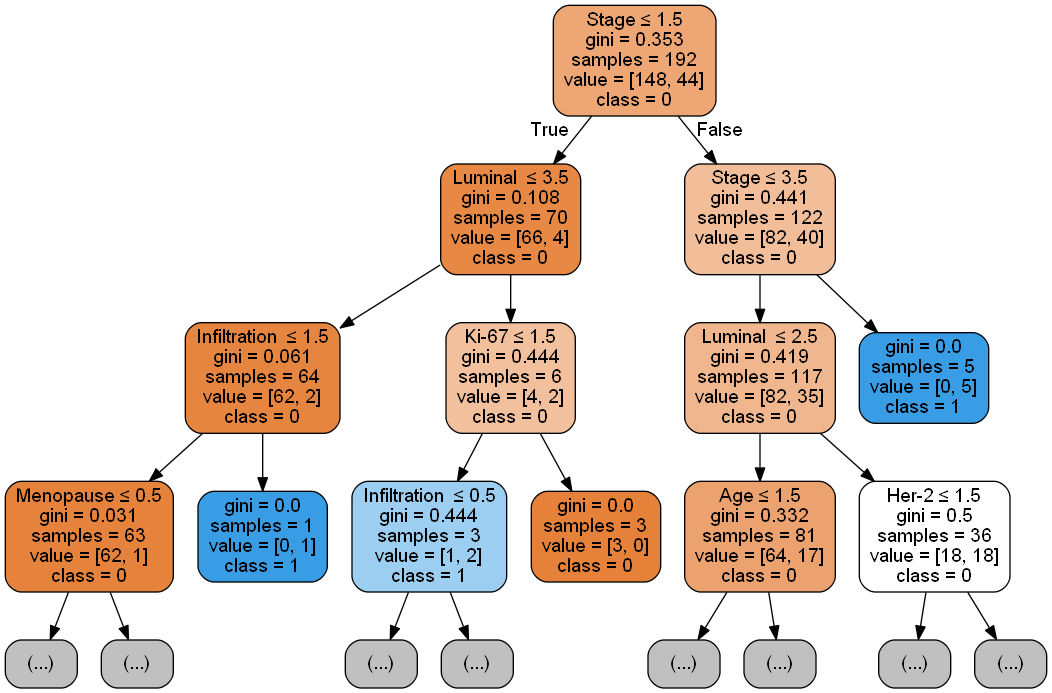

In [42]:
dot_data = tree.export_graphviz(best_estimator, out_file=None, 
                         feature_names=data.columns[1:],  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True,
                         max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 
# graph.write_svg('tree.svg')

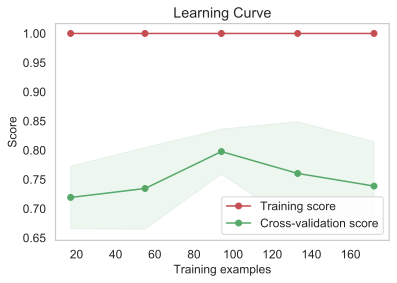

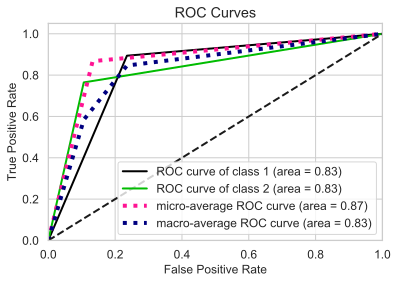

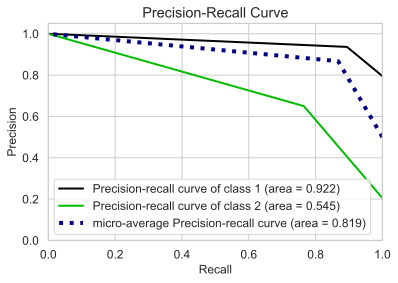

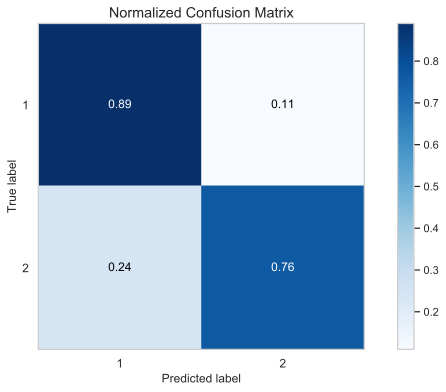

In [43]:
skplt.estimators.plot_learning_curve(best_estimator, X_train, y_train, cv=10);
# plt.savefig('learncurve.svg')

predicted_probas = best_estimator.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, predicted_probas);
# plt.savefig('roc.svg')

y_probas = best_estimator.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas);
# plt.savefig('prcurve.svg')

y_pred = best_estimator.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, labels=[1,2], figsize=(12,6));
# plt.savefig('confusionmatrix.svg')

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.89      0.91        66
           2       0.65      0.76      0.70        17

    accuracy                           0.87        83
   macro avg       0.79      0.83      0.81        83
weighted avg       0.88      0.87      0.87        83

